Выполнено Олейник Софией в рамках дисциплины "Аналитика данных на Python" магистратуры ИТМО.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


In [3]:
# считываем данные с явным указанием типа

data = pd.read_csv(
    "data/Econom_Cities_data.csv",
    sep=";",
    decimal=",",
    dtype = {
        "City": str,
        "Work": int,
        "Price": float,
        "Salary": float
    }
)
data.set_index("City", inplace=True)
data.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


Данные описывают финансовое состояние жителей того ил иного города:
- "Price" - индекс цен 112 товаров и услуг;
- "Salary" - индекс зарплаты за 1 час работы;
- "Work" - взвешенное среднее числа рабочих часов.

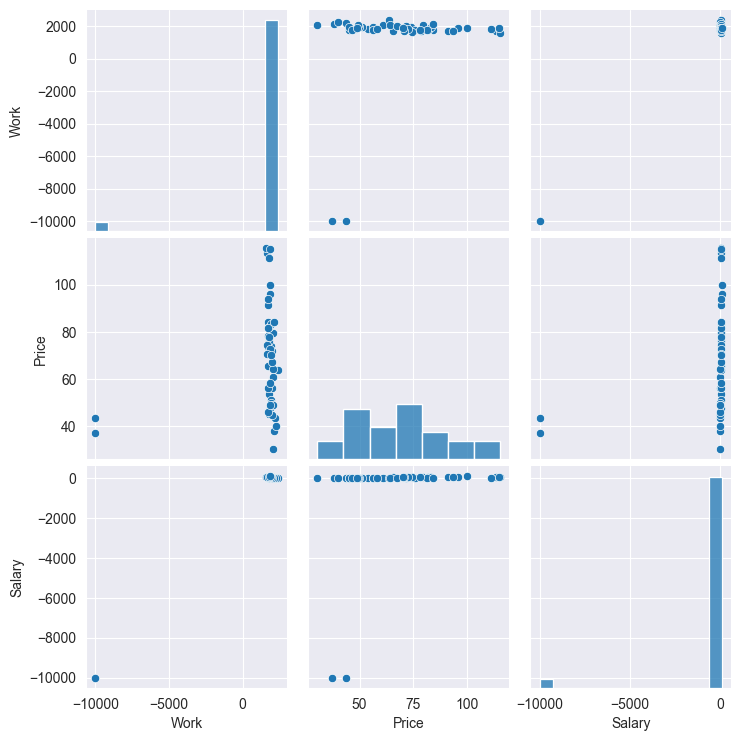

In [30]:
# смотрим на распределение данных
sns.pairplot(data=data);

Видны выбросы. Почистим их с помощью квантилей.

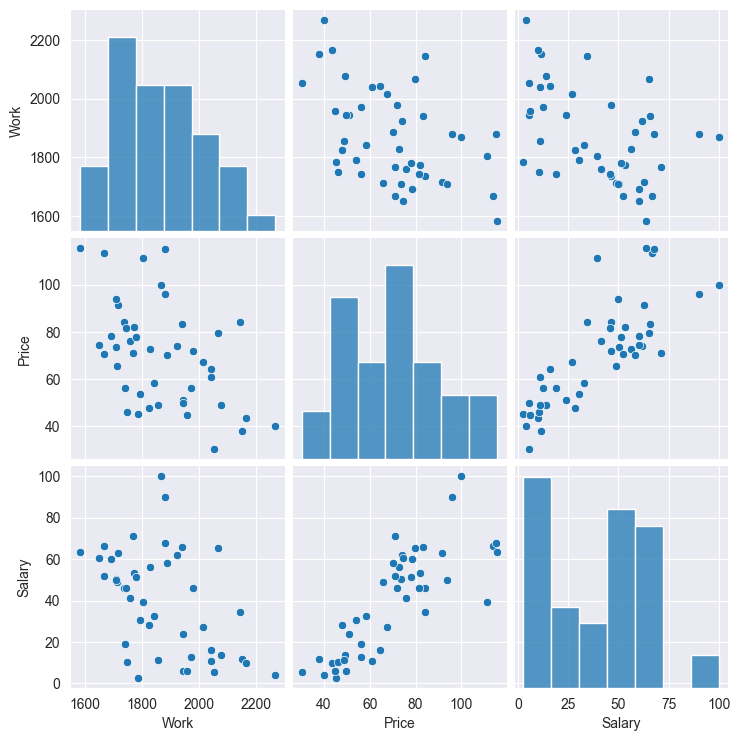

In [31]:
outliers_masks = []
data_cleaned = data.copy()
for col in data.columns:
    # находим квантили и межквантильный размах
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # чистим данные, которые меньше или больше нижней или верхней границ
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    data_cleaned = data_cleaned[(data_cleaned[col] >= lower) & (data_cleaned[col] <= upper)]

sns.pairplot(data=data_cleaned);

Проведем стандартизацию данных, чтобы одни признаки не доминировали над другими за счет порядка.

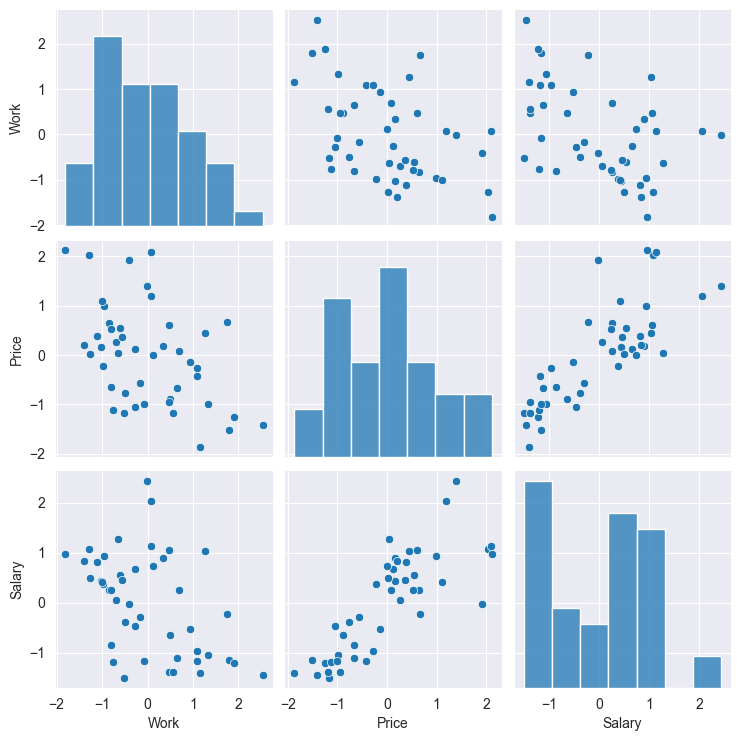

In [32]:
scaler = StandardScaler()
# обучаем скейлер и трансформируем числовые данные
data_scaled = scaler.fit_transform(data_cleaned)
data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned.columns, index=data_cleaned.index)

sns.pairplot(data=data_scaled);

In [33]:
data_scaled.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.983144,-0.217146,0.372285
Athens,-0.488117,-0.769372,-0.380924
Bogota,1.796625,-1.513472,-1.146282
Bombay,1.161975,-1.869142,-1.397352
Brussels,-1.021223,0.166604,0.433028


Кластеризуем по методу Уорда, вычисляя евклидово расстояние между точками.

Объект linkage содержит следующие значения:
- link[:, 0] - индекс первого объединяемого кластера;
- link[:, 1] - индекс второго объединяемого кластера;
- link[:, 2] - дистанция между объединяемыми кластерами;
- link[:, 3] - количество наблюдений в новом кластере.

In [34]:
link = linkage(data_scaled, 'ward', 'euclidean')
print(link[:5, :])

[[19.         32.          0.13010169  2.        ]
 [25.         43.          0.20874631  2.        ]
 [24.         27.          0.24160164  2.        ]
 [ 6.         36.          0.26400717  2.        ]
 [ 2.         16.          0.28625666  2.        ]]


Text(0.5, 1.0, 'Дендрограмма кластеров')

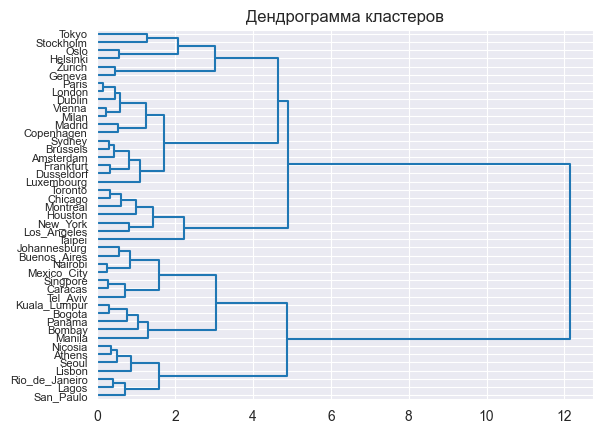

In [35]:
dn = dendrogram(link,
                # подписи
                labels=data_scaled.index.tolist(),
                # без порога кластеризации
                color_threshold=-1,
                # вертикальная подпись
                orientation="right"
)
plt.title("Дендрограмма кластеров")

Добавим к данным столбец о принадлежности к тому или иному кластеру.

In [36]:
threshold = 0.3 * max(link[:, 2])
print("Порог кластеризации: ", threshold)

data_scaled['cluster'] = fcluster(link, threshold, criterion='distance')

Порог кластеризации:  3.6426923448692183


Посмотрим на распределение кластеров.

<Axes: xlabel='cluster', ylabel='Count'>

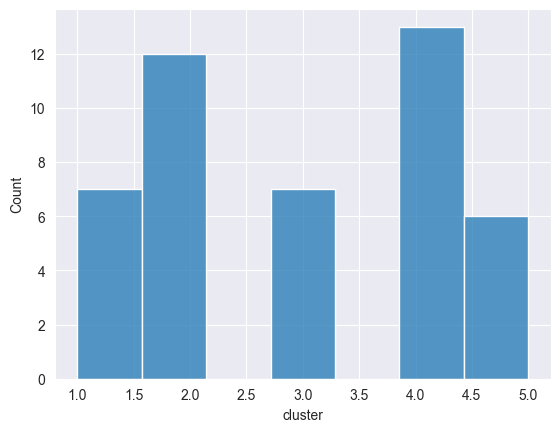

In [37]:
sns.histplot(data=data_scaled.cluster)

Посмотрим по методу "локтя", как меняется расстояние между кластерами на каждой итерации.

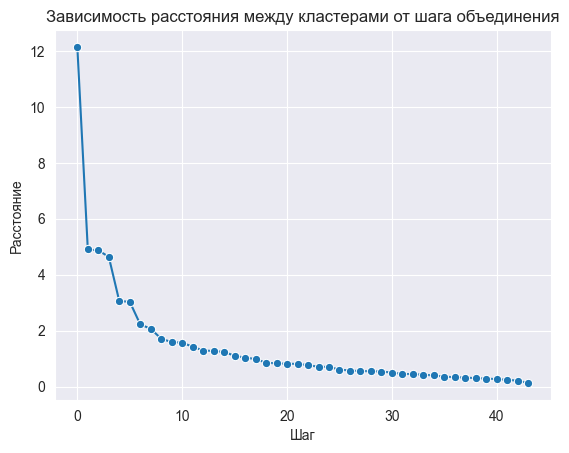

In [38]:
# берем значения из link, где были записаны исторические данные по расстояниям в процессе объединения
dist_rev = link[::-1, 2]
steps = range(0, len(dist_rev))
sns.lineplot(x=steps, y=dist_rev, marker='o')
plt.xlabel("Шаг")
plt.ylabel("Расстояние")
plt.title("Зависимость расстояния между кластерами от шага объединения");

Видно, что примерно после 8 шага расстояние перестает сильно меняться, так что вероятнее всего брать порог кластеризации меньше 1,8 уже не имеет большого смысла. Посмотрим, какое распределение кластеров, а также средние значения при пороге, равном 5, 3,5 и 1,8.


Средние значения признаков для 2 кластеров:
                Work      Price     Salary
cluster                                   
1        1959.210526  50.115789  14.789474
2        1802.923077  84.946154  58.088462

Средние значения признаков для 5 кластеров:
                Work       Price     Salary
cluster                                    
1        1798.857143   50.942857  19.214286
2        2052.750000   49.633333  12.208333
3        1967.428571   76.585714  55.457143
4        1724.692308   78.553846  53.407692
5        1780.500000  108.550000  71.300000

Средние значения признаков для 9 кластеров:
                Work       Price     Salary
cluster                                    
1        1798.857143   50.942857  19.214286
2        2143.400000   40.180000   8.900000
3        1988.000000   56.385714  14.571429
4        1937.833333   75.300000  58.950000
5        2145.000000   84.300000  34.500000
6        1724.692308   78.553846  53.407692
7        1874.000000   97.950000 

<Figure size 640x480 with 0 Axes>

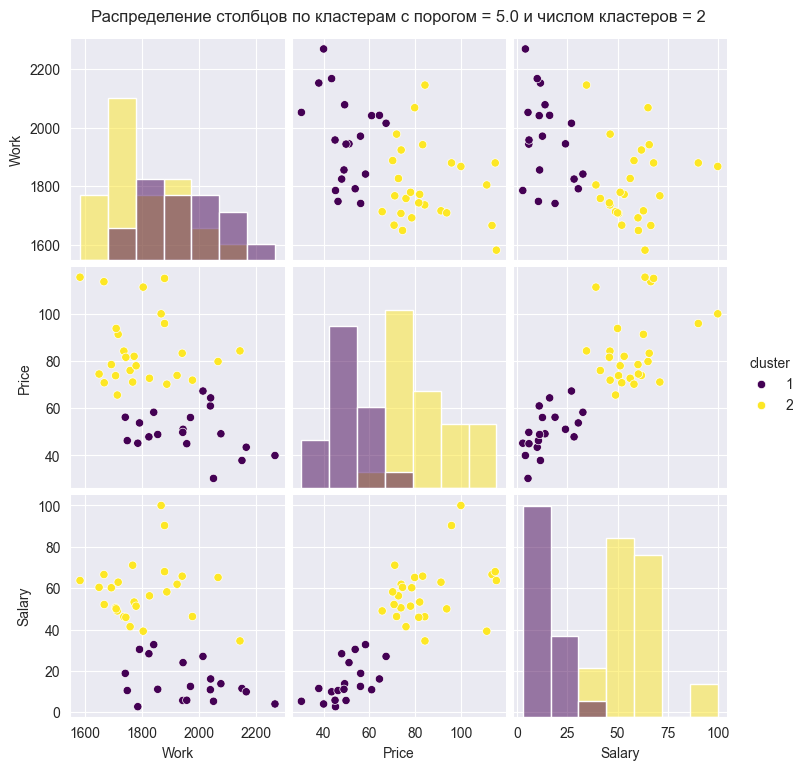

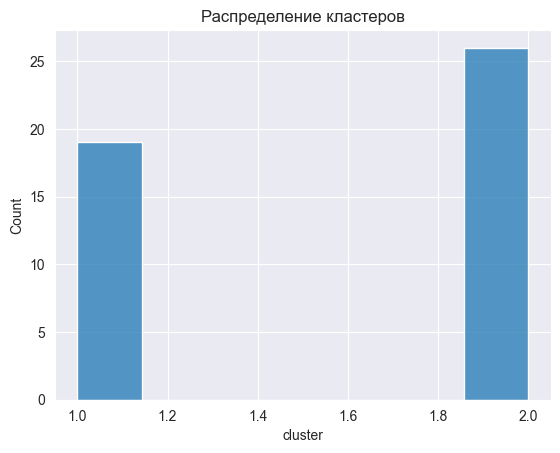

<Figure size 640x480 with 0 Axes>

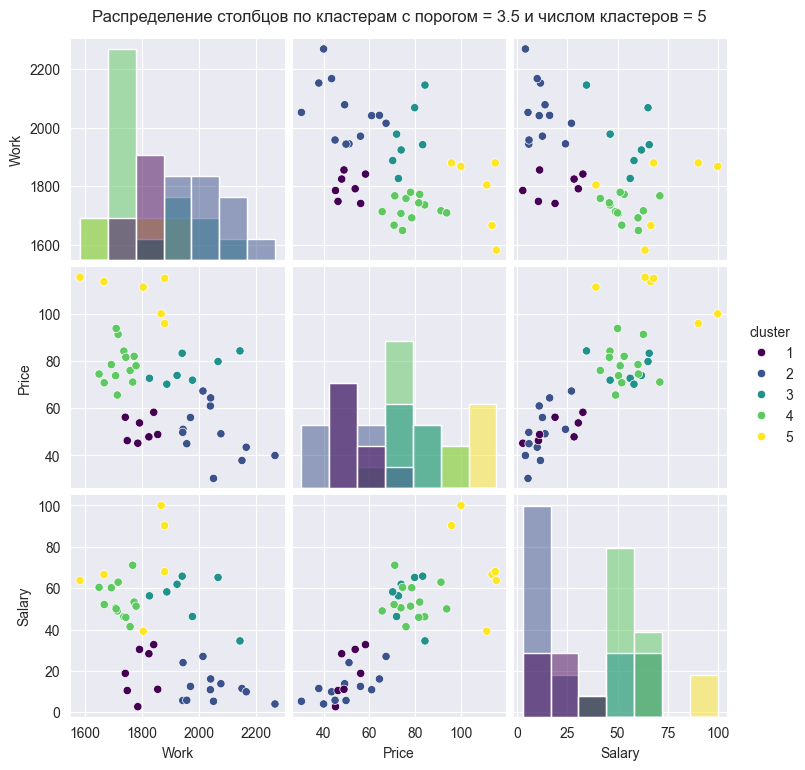

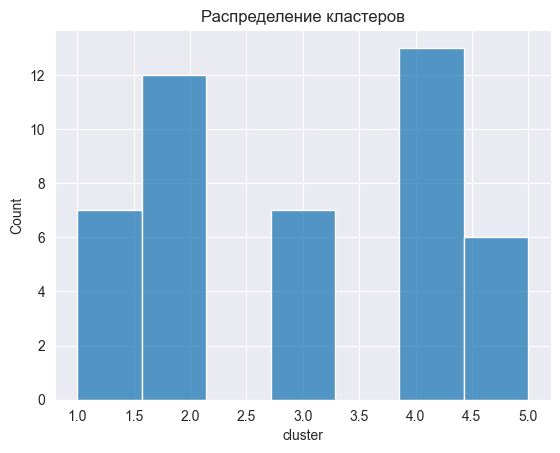

<Figure size 640x480 with 0 Axes>

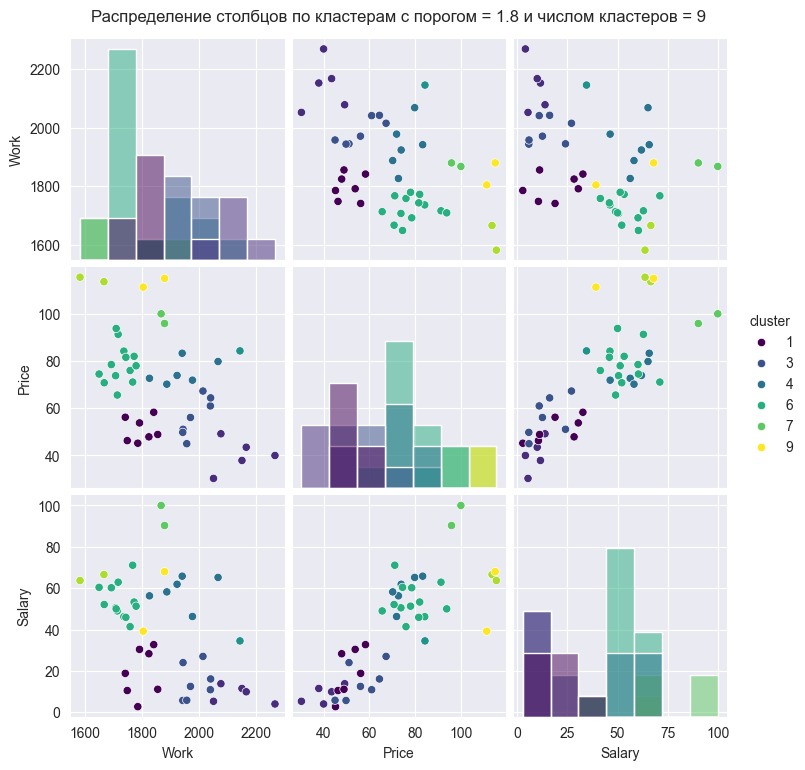

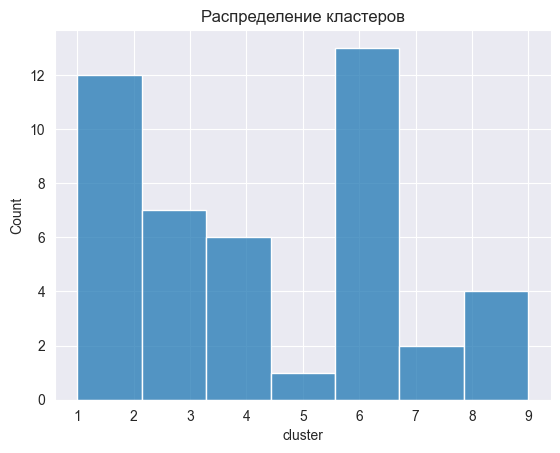

In [41]:
thresholds = [5.0, 3.5, 1.8]

for threshold in thresholds:
    data_cleaned['cluster'] = fcluster(link, threshold, criterion='distance')

    fig = plt.figure()
    # построение диаграммы распределения данных
    sns.pairplot(data_cleaned,
                 hue='cluster',
                 palette='viridis',
                 diag_kind='hist')
    # подсчет количества кластеров
    unique_count = len(data_cleaned['cluster'].unique())
    plt.suptitle(f'Распределение столбцов по кластерам c порогом = {threshold} и числом кластеров = {unique_count}', y=1.02)

    fig = plt.figure()
    sns.histplot(data=data_cleaned['cluster'])
    plt.title("Распределение кластеров")

    print(f"\nСредние значения признаков для {unique_count} кластеров:")
    print(data_cleaned.groupby(['cluster']).mean())

Кластеризация нацелена разделение городов по финансовому благополучию. По графикам и значениям средних признаков видно, что прямое влияние имеет индекс цен, а также зарплата за 1 час работы - чем больше эти показатели, тем лучше экономические условия жителей этих городов. Более нелинейную зависимость имеет количество отработанных часов - не всегда малое количество отработанных часов говорит о достатке и высокооплачиваемой должности человека.

С увеличением количества кластеров все больше виднеется "средняя прослойка" между городами. Разное количество кластеров позволяет отследить разную информацию.

Малое количество кластеров (2) необходимо в случаях, когда не нужно большое количество информации - города делятся на "черное" и "белое". Это может пригодится для составления какой-то другой статистики и использования этих данных в качестве признакаю

Среднее количество кластеров (3-6) необходимо в случаях, когда уже нужна более точная информация о "средних" слоях населения.

Большое количество кластеров (>6) может быть полезно для отслеживания какой-то внутренней статистики "средних" слоев.

Для текущей информации видно, что зажиточных слоев больше, чем бедных или богатых.